In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

In [2]:
# Say we have some population of galaxies
ngals = 10
names = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 'y']
types = [float]*len(names)
galaxies = np.zeros(ngals, dtype=list(zip(names,types)))

# Make up some stuff
galaxies['ra'] = np.arange(ngals)/ngals*360.
galaxies['dec'] = -np.arange(ngals)/ngals*90

filternames = [ 'u', 'g', 'r', 'i', 'z', 'y']
for filtername in filternames:
    galaxies[filtername] = np.random.rand(ngals) + 22.
    

In [3]:
# Let's make a new metric that computes the coadded depth (with dist extinction) at a point in every filter
class Photo_z_quality(metrics.BaseMetric):
    """Calc exgal coadded depth in each filter and then do a thing
    """
    def __init__(self, m5Col='fiveSigmaDepth', units='XXXsome kind of unit', maps=['DustMap'],
                 wavelen_min=None , wavelen_max=None , wavelen_step=1.,filterCol='filter',
                 **kwargs):
        """
        ugh, yeah, put in a docstring
        """
        self.filternames = ['u', 'g', 'r', 'i', 'z', 'y']
        self.m5Col = m5Col
        self.filterCol = filterCol
        # Make a coadd metric for each filter
        self.coadd_metric_dict = {}
        for filtername in self.filternames:
            self.coadd_metric_dict[filtername] = metrics.ExgalM5(lsstFilter=filtername, 
                                                          m5Col=m5Col, units=units, 
                                                          maps=maps, wavelen_min=wavelen_min,
                                                          wavelen_max=wavelen_max, 
                                                          wavelen_step=1.,**kwargs)
        super(Photo_z_quality, self).__init__(col=[self.m5Col, self.filterCol],
                                              maps=maps, units=units, **kwargs)
    def run(self, dataslice, slicePoint=None):
        coadd_depths = []
        for filtername in self.filternames:
            in_filt = np.where(dataslice[self.filterCol] == filtername)
            coadd_depths.append(self.coadd_metric_dict[filtername].run(dataslice[in_filt],
                                                                       slicePoint=slicePoint))
        # OK, now we have the coadded depths in each filter at some point in the sky
        
        # I don't know, let's look at the difference between depth and galaxy mag and take a mean.
        # In practice, call some code that does something smart.
        result = []
        for i,filtername in enumerate(self.filternames):
            result.append(coadd_depths[i] - slicePoint[filtername])
        return np.mean(result)
        

In [4]:
# Connect to the database
runName = 'baseline2018a'
#This next command assumes you have downloaded baseline2018a.db into the tutorials directory in this repo.
#Change this path according to your datbase and where it is saved.
opsdb = db.OpsimDatabase('baseline2018a.db')
outDir = 'mafOut'
resultsDb = db.ResultsDb(outDir=outDir)

In [5]:
# Now to set up a slicer that will go to each galaxy point. Let's use dithered positions for the pointings to
# be more realistic
slicer = slicers.UserPointsSlicer(galaxies['ra'], galaxies['dec'], 
                                  latCol='randomDitherFieldPerNightDec',
                                  lonCol='randomDitherFieldPerNightRa' , latLonDeg=True)
# Let's also tell the slicer about the galaxy magnitudes so that info get passed to metric.run method
for filtername in filternames:
    slicer.slicePoints[filtername] = galaxies[filtername]
# NOTE: because we are passing in arrays, MAF assumes each mag value goes with a given point. I'm pretty sure if
# you passed in a scalar, that would get passed to every point, so it would be the same as taking a single galaxy 
# and moving it around the sky. (Which can be nice because then you can use the healpixSlicer and just map the whole sky)

In [6]:
metric = Photo_z_quality()
# How many years to look at
nyears = 2
sql = 'night < %f' % (365.25*nyears)
bundle = metricBundles.MetricBundle(metric, slicer, sql, runName=runName)

In [7]:
bundleList = [bundle]
bundleDict = metricBundles.makeBundlesDictFromList(bundleList)
bgroup = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)
bgroup.runAll()

Querying database SummaryAllProps with constraint night < 730.500000 for columns ['fieldDec', 'night', 'filter', 'fiveSigmaDepth', 'fieldId', 'fieldRA']
Found 453105 visits
Running:  ['baseline2018a_Photo_z_quality_fiveSigmaDepth_filter_night_lt_730_500000_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


Plotting figures with "night < 730.500000" constraint now.
Plotting complete.


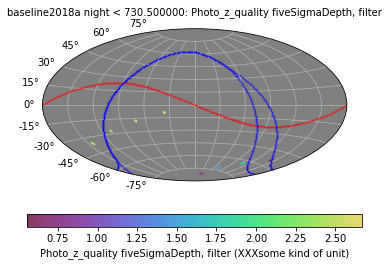

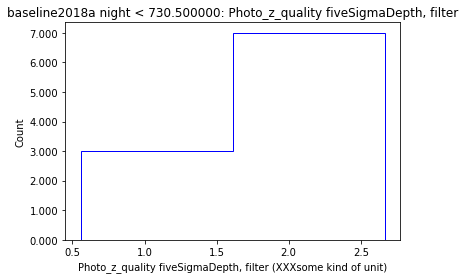

In [8]:
bgroup.plotAll(closefigs=False)

In [9]:
# And now we can look at the results too.
bundle.metricValues.data

array([ 2.39052494,  2.66810641,  2.62787126,  2.36625874,  2.4314603 ,
        2.61447612,  0.55685709,  1.79656321,  1.50876935,  0.73479407])